In [1]:
import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Dense, Activation, Lambda
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from config_reader import config_reader
import scipy
import math
import json
from os import listdir
from os.path import isfile, join
from scipy.ndimage.filters import gaussian_filter
%matplotlib inline
import cv2
import matplotlib
import pylab as plt
import numpy as np
import util
import pandas as pd
import pickle
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_distances
from seaborn import heatmap
from copy import deepcopy
from pytube import YouTube

/home/parker/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [169]:
# yt = YouTube('https://www.youtube.com/watch?v=6UTLhgX_k1Y')
# yt.streams.filter(subtype='mp4',progressive=False).first().download()

Helper functions to create a model

In [2]:
def relu(x): 
    return Activation('relu')(x)

def conv(x, nf, ks, name):
    x1 = Conv2D(nf, (ks, ks), padding='same', name=name)(x)
    return x1

def pooling(x, ks, st, name):
    x = MaxPooling2D((ks, ks), strides=(st, st), name=name)(x)
    return x

def vgg_block(x):
     
    # Block 1
    x = conv(x, 64, 3, "conv1_1")
    x = relu(x)
    x = conv(x, 64, 3, "conv1_2")
    x = relu(x)
    x = pooling(x, 2, 2, "pool1_1")

    # Block 2
    x = conv(x, 128, 3, "conv2_1")
    x = relu(x)
    x = conv(x, 128, 3, "conv2_2")
    x = relu(x)
    x = pooling(x, 2, 2, "pool2_1")
    
    # Block 3
    x = conv(x, 256, 3, "conv3_1")
    x = relu(x)    
    x = conv(x, 256, 3, "conv3_2")
    x = relu(x)    
    x = conv(x, 256, 3, "conv3_3")
    x = relu(x)    
    x = conv(x, 256, 3, "conv3_4")
    x = relu(x)    
    x = pooling(x, 2, 2, "pool3_1")
    
    # Block 4
    x = conv(x, 512, 3, "conv4_1")
    x = relu(x)    
    x = conv(x, 512, 3, "conv4_2")
    x = relu(x)    
    
    # Additional non vgg layers
    x = conv(x, 256, 3, "conv4_3_CPM")
    x = relu(x)
    x = conv(x, 128, 3, "conv4_4_CPM")
    x = relu(x)
    
    return x

def stage1_block(x, num_p, branch):
    
    # Block 1        
    x = conv(x, 128, 3, "conv5_1_CPM_L%d" % branch)
    x = relu(x)
    x = conv(x, 128, 3, "conv5_2_CPM_L%d" % branch)
    x = relu(x)
    x = conv(x, 128, 3, "conv5_3_CPM_L%d" % branch)
    x = relu(x)
    x = conv(x, 512, 1, "conv5_4_CPM_L%d" % branch)
    x = relu(x)
    x = conv(x, num_p, 1, "conv5_5_CPM_L%d" % branch)
    
    return x

def stageT_block(x, num_p, stage, branch):
        
    # Block 1        
    x = conv(x, 128, 7, "Mconv1_stage%d_L%d" % (stage, branch))
    x = relu(x)
    x = conv(x, 128, 7, "Mconv2_stage%d_L%d" % (stage, branch))
    x = relu(x)
    x = conv(x, 128, 7, "Mconv3_stage%d_L%d" % (stage, branch))
    x = relu(x)
    x = conv(x, 128, 7, "Mconv4_stage%d_L%d" % (stage, branch))
    x = relu(x)
    x = conv(x, 128, 7, "Mconv5_stage%d_L%d" % (stage, branch))
    x = relu(x)
    x = conv(x, 128, 1, "Mconv6_stage%d_L%d" % (stage, branch))
    x = relu(x)
    x = conv(x, num_p, 1, "Mconv7_stage%d_L%d" % (stage, branch))
    
    return x

Create keras model and load weights

In [3]:
weights_path = "model/model.h5" # orginal weights converted from caffe
#weights_path = "training/weights.best.h5" # weights tarined from scratch 

input_shape = (None,None,3)

img_input = Input(shape=input_shape)

stages = 6
np_branch1 = 38
np_branch2 = 19

img_normalized = Lambda(lambda x: x / 256 - 0.5)(img_input)  # [-0.5, 0.5]

# VGG
stage0_out = vgg_block(img_normalized)

# stage 1
stage1_branch1_out = stage1_block(stage0_out, np_branch1, 1)
stage1_branch2_out = stage1_block(stage0_out, np_branch2, 2)
x = Concatenate()([stage1_branch1_out, stage1_branch2_out, stage0_out])

# stage t >= 2
for sn in range(2, stages + 1):
    stageT_branch1_out = stageT_block(x, np_branch1, sn, 1)
    stageT_branch2_out = stageT_block(x, np_branch2, sn, 2)
    if (sn < stages):
        x = Concatenate()([stageT_branch1_out, stageT_branch2_out, stage0_out])

model = Model(img_input, [stageT_branch1_out, stageT_branch2_out])
model.load_weights(weights_path)

Show sample heatmaps for right elbow and paf for right wrist and right elbow

In [4]:
param, model_params = config_reader()

In [5]:
def find_heatmap(oriImg,multi = 2):
    param, model_params = config_reader()
    multiplier = [x * model_params['boxsize'] / oriImg.shape[0] for x in param['scale_search']]
    heatmap_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 19))
    stride = model_params['stride']
    multiplier = multiplier[:multi]
    for m in range(len(multiplier)):
        scale = multiplier[m]
        imageToTest = cv2.resize(oriImg, (0,0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
        imageToTest_padded, pad = util.padRightDownCorner(imageToTest, stride, model_params['padValue'])        

        input_img = np.transpose(np.float32(imageToTest_padded[:,:,:,np.newaxis]), (3,0,1,2)) # required shape (1, width, height, channels) 
#         print("Input shape: " + str(input_img.shape))  

        output_blobs = model.predict(input_img)
#         print("Output shape (heatmap): " + str(output_blobs[1].shape))

        # extract outputs, resize, and remove padding
        heatmap = np.squeeze(output_blobs[1]) # output 1 is heatmaps
        heatmap = cv2.resize(heatmap, (0,0), fx=stride, fy=stride, interpolation=cv2.INTER_CUBIC)
        heatmap = heatmap[:imageToTest_padded.shape[0]-pad[2], :imageToTest_padded.shape[1]-pad[3], :]
        heatmap = cv2.resize(heatmap, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)

        heatmap_avg = heatmap_avg + heatmap / len(multiplier)
    return heatmap_avg

Heatmap for right knee. Note that the body part is encoded in the 3th channel so in this case right knee is 
at index 9. All body parts are defined in config: 
part_str = [nose, neck, Rsho, Relb, Rwri, Lsho, Lelb, Lwri, Rhip, Rkne, Rank, Lhip, Lkne, Lank, Leye, Reye, Lear, Rear, pt19]

part_str = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

Visualise all detected body parts. Note that we use peaks in heatmaps

In [6]:
def find_peaks(heatmap_avg):
    all_peaks = []
    peak_counter = 0

    for part in range(18):
        map_ori = heatmap_avg[:,:,part]
        map = gaussian_filter(map_ori, sigma=3)

        map_left = np.zeros(map.shape)
        map_left[1:,:] = map[:-1,:]
        map_right = np.zeros(map.shape)
        map_right[:-1,:] = map[1:,:]
        map_up = np.zeros(map.shape)
        map_up[:,1:] = map[:,:-1]
        map_down = np.zeros(map.shape)
        map_down[:,:-1] = map[:,1:]

        peaks_binary = np.logical_and.reduce((map>=map_left, map>=map_right, map>=map_up, map>=map_down, map > param['thre1']))
        peaks = list(zip(np.nonzero(peaks_binary)[1], np.nonzero(peaks_binary)[0])) # note reverse
        peaks_with_score = [x + (map_ori[x[1],x[0]],) for x in peaks]
        id = range(peak_counter, peak_counter + len(peaks))
        peaks_with_score_and_id = [peaks_with_score[i] + (id[i],part) for i in range(len(id))]

        all_peaks.extend(peaks_with_score_and_id)
        peak_counter += len(peaks)
    return all_peaks

In [7]:
def find_feet_head(all_peaks):
    outputDict = {
        'x': [],
        'y': [],
        'part': []
    }
    for peaks in all_peaks:
        outputDict['x'].append(peaks[0])
        outputDict['y'].append(peaks[1])
        outputDict['part'].append(peaks[-1])
    return outputDict

In [8]:
theVideo = 'squash-trim.avi'

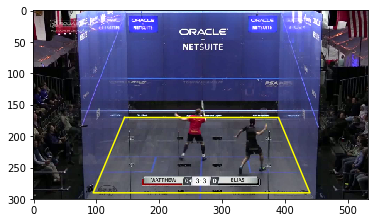

In [12]:
cap = cv2.VideoCapture(theVideo)

ret,frame = cap.read()

minDimImage = 300
minDim = frame.shape.index(min(frame.shape[:-2]))
imgScale = minDimImage / frame.shape[minDim]



frame = cv2.resize(frame, (0,0), fx=imgScale, fy=imgScale)

plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))

courtX = [145,390,440,95,145]
courtY = [170,170,290,290,170]
plt.plot(courtX,courtY,c='yellow')

In [10]:
botLeft = 90
botRight = 440

In [174]:
cap = cv2.VideoCapture(theVideo)

allPoints = []

length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# take first frame of the video
ret,frame = cap.read()
minDim = frame.shape.index(min(frame.shape[:-2]))
imgScale = minDimImage / frame.shape[minDim]
# Setup the termination criteria, either 10 iteration or move by atleast 1 pt
# count = 1
count = -1

while ret:
    count+=1
    print (f'Finding points for frame {count} out of {length}')
    ret,frame = cap.read()

    
    if count % 30 == 0:
        frame = cv2.resize(frame, (0,0), fx=imgScale, fy=imgScale)
        htm = find_heatmap(frame,1)
        pks = find_peaks(htm)
        peakDict = find_feet_head(pks)
        for i in range(len(peakDict['x'])):
            if peakDict['x'][i] > botLeft and peakDict['x'][i] < botRight:
                allPoints.append((peakDict['x'][i],peakDict['y'][i],peakDict['part'][i],count))

cv2.destroyAllWindows()
cap.release()

Finding points for frame 0 out of 2334
Finding points for frame 1 out of 2334
Finding points for frame 2 out of 2334
Finding points for frame 3 out of 2334
Finding points for frame 4 out of 2334
Finding points for frame 5 out of 2334
Finding points for frame 6 out of 2334
Finding points for frame 7 out of 2334
Finding points for frame 8 out of 2334
Finding points for frame 9 out of 2334
Finding points for frame 10 out of 2334
Finding points for frame 11 out of 2334
Finding points for frame 12 out of 2334
Finding points for frame 13 out of 2334
Finding points for frame 14 out of 2334
Finding points for frame 15 out of 2334
Finding points for frame 16 out of 2334
Finding points for frame 17 out of 2334
Finding points for frame 18 out of 2334
Finding points for frame 19 out of 2334
Finding points for frame 20 out of 2334
Finding points for frame 21 out of 2334
Finding points for frame 22 out of 2334
Finding points for frame 23 out of 2334
Finding points for frame 24 out of 2334
Finding po

Finding points for frame 211 out of 2334
Finding points for frame 212 out of 2334
Finding points for frame 213 out of 2334
Finding points for frame 214 out of 2334
Finding points for frame 215 out of 2334
Finding points for frame 216 out of 2334
Finding points for frame 217 out of 2334
Finding points for frame 218 out of 2334
Finding points for frame 219 out of 2334
Finding points for frame 220 out of 2334
Finding points for frame 221 out of 2334
Finding points for frame 222 out of 2334
Finding points for frame 223 out of 2334
Finding points for frame 224 out of 2334
Finding points for frame 225 out of 2334
Finding points for frame 226 out of 2334
Finding points for frame 227 out of 2334
Finding points for frame 228 out of 2334
Finding points for frame 229 out of 2334
Finding points for frame 230 out of 2334
Finding points for frame 231 out of 2334
Finding points for frame 232 out of 2334
Finding points for frame 233 out of 2334
Finding points for frame 234 out of 2334
Finding points f

Finding points for frame 421 out of 2334
Finding points for frame 422 out of 2334
Finding points for frame 423 out of 2334
Finding points for frame 424 out of 2334
Finding points for frame 425 out of 2334
Finding points for frame 426 out of 2334
Finding points for frame 427 out of 2334
Finding points for frame 428 out of 2334
Finding points for frame 429 out of 2334
Finding points for frame 430 out of 2334
Finding points for frame 431 out of 2334
Finding points for frame 432 out of 2334
Finding points for frame 433 out of 2334
Finding points for frame 434 out of 2334
Finding points for frame 435 out of 2334
Finding points for frame 436 out of 2334
Finding points for frame 437 out of 2334
Finding points for frame 438 out of 2334
Finding points for frame 439 out of 2334
Finding points for frame 440 out of 2334
Finding points for frame 441 out of 2334
Finding points for frame 442 out of 2334
Finding points for frame 443 out of 2334
Finding points for frame 444 out of 2334
Finding points f

Finding points for frame 631 out of 2334
Finding points for frame 632 out of 2334
Finding points for frame 633 out of 2334
Finding points for frame 634 out of 2334
Finding points for frame 635 out of 2334
Finding points for frame 636 out of 2334
Finding points for frame 637 out of 2334
Finding points for frame 638 out of 2334
Finding points for frame 639 out of 2334
Finding points for frame 640 out of 2334
Finding points for frame 641 out of 2334
Finding points for frame 642 out of 2334
Finding points for frame 643 out of 2334
Finding points for frame 644 out of 2334
Finding points for frame 645 out of 2334
Finding points for frame 646 out of 2334
Finding points for frame 647 out of 2334
Finding points for frame 648 out of 2334
Finding points for frame 649 out of 2334
Finding points for frame 650 out of 2334
Finding points for frame 651 out of 2334
Finding points for frame 652 out of 2334
Finding points for frame 653 out of 2334
Finding points for frame 654 out of 2334
Finding points f

Finding points for frame 841 out of 2334
Finding points for frame 842 out of 2334
Finding points for frame 843 out of 2334
Finding points for frame 844 out of 2334
Finding points for frame 845 out of 2334
Finding points for frame 846 out of 2334
Finding points for frame 847 out of 2334
Finding points for frame 848 out of 2334
Finding points for frame 849 out of 2334
Finding points for frame 850 out of 2334
Finding points for frame 851 out of 2334
Finding points for frame 852 out of 2334
Finding points for frame 853 out of 2334
Finding points for frame 854 out of 2334
Finding points for frame 855 out of 2334
Finding points for frame 856 out of 2334
Finding points for frame 857 out of 2334
Finding points for frame 858 out of 2334
Finding points for frame 859 out of 2334
Finding points for frame 860 out of 2334
Finding points for frame 861 out of 2334
Finding points for frame 862 out of 2334
Finding points for frame 863 out of 2334
Finding points for frame 864 out of 2334
Finding points f

Finding points for frame 1051 out of 2334
Finding points for frame 1052 out of 2334
Finding points for frame 1053 out of 2334
Finding points for frame 1054 out of 2334
Finding points for frame 1055 out of 2334
Finding points for frame 1056 out of 2334
Finding points for frame 1057 out of 2334
Finding points for frame 1058 out of 2334
Finding points for frame 1059 out of 2334
Finding points for frame 1060 out of 2334
Finding points for frame 1061 out of 2334
Finding points for frame 1062 out of 2334
Finding points for frame 1063 out of 2334
Finding points for frame 1064 out of 2334
Finding points for frame 1065 out of 2334
Finding points for frame 1066 out of 2334
Finding points for frame 1067 out of 2334
Finding points for frame 1068 out of 2334
Finding points for frame 1069 out of 2334
Finding points for frame 1070 out of 2334
Finding points for frame 1071 out of 2334
Finding points for frame 1072 out of 2334
Finding points for frame 1073 out of 2334
Finding points for frame 1074 out 

Finding points for frame 1261 out of 2334
Finding points for frame 1262 out of 2334
Finding points for frame 1263 out of 2334
Finding points for frame 1264 out of 2334
Finding points for frame 1265 out of 2334
Finding points for frame 1266 out of 2334
Finding points for frame 1267 out of 2334
Finding points for frame 1268 out of 2334
Finding points for frame 1269 out of 2334
Finding points for frame 1270 out of 2334
Finding points for frame 1271 out of 2334
Finding points for frame 1272 out of 2334
Finding points for frame 1273 out of 2334
Finding points for frame 1274 out of 2334
Finding points for frame 1275 out of 2334
Finding points for frame 1276 out of 2334
Finding points for frame 1277 out of 2334
Finding points for frame 1278 out of 2334
Finding points for frame 1279 out of 2334
Finding points for frame 1280 out of 2334
Finding points for frame 1281 out of 2334
Finding points for frame 1282 out of 2334
Finding points for frame 1283 out of 2334
Finding points for frame 1284 out 

Finding points for frame 1471 out of 2334
Finding points for frame 1472 out of 2334
Finding points for frame 1473 out of 2334
Finding points for frame 1474 out of 2334
Finding points for frame 1475 out of 2334
Finding points for frame 1476 out of 2334
Finding points for frame 1477 out of 2334
Finding points for frame 1478 out of 2334
Finding points for frame 1479 out of 2334
Finding points for frame 1480 out of 2334
Finding points for frame 1481 out of 2334
Finding points for frame 1482 out of 2334
Finding points for frame 1483 out of 2334
Finding points for frame 1484 out of 2334
Finding points for frame 1485 out of 2334
Finding points for frame 1486 out of 2334
Finding points for frame 1487 out of 2334
Finding points for frame 1488 out of 2334
Finding points for frame 1489 out of 2334
Finding points for frame 1490 out of 2334
Finding points for frame 1491 out of 2334
Finding points for frame 1492 out of 2334
Finding points for frame 1493 out of 2334
Finding points for frame 1494 out 

Finding points for frame 1681 out of 2334
Finding points for frame 1682 out of 2334
Finding points for frame 1683 out of 2334
Finding points for frame 1684 out of 2334
Finding points for frame 1685 out of 2334
Finding points for frame 1686 out of 2334
Finding points for frame 1687 out of 2334
Finding points for frame 1688 out of 2334
Finding points for frame 1689 out of 2334
Finding points for frame 1690 out of 2334
Finding points for frame 1691 out of 2334
Finding points for frame 1692 out of 2334
Finding points for frame 1693 out of 2334
Finding points for frame 1694 out of 2334
Finding points for frame 1695 out of 2334
Finding points for frame 1696 out of 2334
Finding points for frame 1697 out of 2334
Finding points for frame 1698 out of 2334
Finding points for frame 1699 out of 2334
Finding points for frame 1700 out of 2334
Finding points for frame 1701 out of 2334
Finding points for frame 1702 out of 2334
Finding points for frame 1703 out of 2334
Finding points for frame 1704 out 

Finding points for frame 1891 out of 2334
Finding points for frame 1892 out of 2334
Finding points for frame 1893 out of 2334
Finding points for frame 1894 out of 2334
Finding points for frame 1895 out of 2334
Finding points for frame 1896 out of 2334
Finding points for frame 1897 out of 2334
Finding points for frame 1898 out of 2334
Finding points for frame 1899 out of 2334
Finding points for frame 1900 out of 2334
Finding points for frame 1901 out of 2334
Finding points for frame 1902 out of 2334
Finding points for frame 1903 out of 2334
Finding points for frame 1904 out of 2334
Finding points for frame 1905 out of 2334
Finding points for frame 1906 out of 2334
Finding points for frame 1907 out of 2334
Finding points for frame 1908 out of 2334
Finding points for frame 1909 out of 2334
Finding points for frame 1910 out of 2334
Finding points for frame 1911 out of 2334
Finding points for frame 1912 out of 2334
Finding points for frame 1913 out of 2334
Finding points for frame 1914 out 

Finding points for frame 2101 out of 2334
Finding points for frame 2102 out of 2334
Finding points for frame 2103 out of 2334
Finding points for frame 2104 out of 2334
Finding points for frame 2105 out of 2334
Finding points for frame 2106 out of 2334
Finding points for frame 2107 out of 2334
Finding points for frame 2108 out of 2334
Finding points for frame 2109 out of 2334
Finding points for frame 2110 out of 2334
Finding points for frame 2111 out of 2334
Finding points for frame 2112 out of 2334
Finding points for frame 2113 out of 2334
Finding points for frame 2114 out of 2334
Finding points for frame 2115 out of 2334
Finding points for frame 2116 out of 2334
Finding points for frame 2117 out of 2334
Finding points for frame 2118 out of 2334
Finding points for frame 2119 out of 2334
Finding points for frame 2120 out of 2334
Finding points for frame 2121 out of 2334
Finding points for frame 2122 out of 2334
Finding points for frame 2123 out of 2334
Finding points for frame 2124 out 

Finding points for frame 2311 out of 2334
Finding points for frame 2312 out of 2334
Finding points for frame 2313 out of 2334
Finding points for frame 2314 out of 2334
Finding points for frame 2315 out of 2334
Finding points for frame 2316 out of 2334
Finding points for frame 2317 out of 2334
Finding points for frame 2318 out of 2334
Finding points for frame 2319 out of 2334
Finding points for frame 2320 out of 2334
Finding points for frame 2321 out of 2334
Finding points for frame 2322 out of 2334
Finding points for frame 2323 out of 2334
Finding points for frame 2324 out of 2334
Finding points for frame 2325 out of 2334
Finding points for frame 2326 out of 2334
Finding points for frame 2327 out of 2334
Finding points for frame 2328 out of 2334
Finding points for frame 2329 out of 2334
Finding points for frame 2330 out of 2334
Finding points for frame 2331 out of 2334
Finding points for frame 2332 out of 2334


In [175]:
len(allPoints)

2397

In [176]:
allPointsDf = pd.DataFrame(allPoints,columns=['x','y','part','frame'])
# pickle.dump(allPointsDf,open('point-track.pkl','wb'))

In [177]:
cap = cv2.VideoCapture(theVideo)

allPoints = []

length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# take first frame of the video
ret,frame = cap.read()
minDim = frame.shape.index(min(frame.shape[:-2]))
imgScale = minDimImage / frame.shape[minDim]

In [178]:
# allPointsDf['sim1'] = -1
# allPointsDf['sim2'] = -1
allPointsDf['labels'] = -1
allPointsDf['playerid'] = -1

In [179]:
def label_player(idx):
    currFrame = allPointsDf[allPointsDf.frame == idx]
    clustFind = KMeans(2)
    labels = clustFind.fit_predict(currFrame[['x','y']])
    currFrame['labels'] = labels
    torsos = currFrame[currFrame.part.isin([2,5,11,8])]
#     print(torsos)
    torsos = torsos.groupby('labels')[['x','y']].median().reset_index()

    allLabels = torsos.labels.unique()
    if 0 in allLabels:
        r1 = int(torsos.loc[torsos.labels == 0,'y'])
        c1 = int(torsos.loc[torsos.labels == 0,'x'])
    else:
        r1 = -10
        c1 = -10
    if 1 in allLabels:
        r2 = int(torsos.loc[torsos.labels == 1,'y'])
        c2 = int(torsos.loc[torsos.labels == 1,'x'])
    else:
        r2 = -10
        c2 = -10
    return r1, c1, r2, c2, currFrame

In [180]:
allPointsDf.head()

,x,y,part,frame,labels,playerid
0,264,160,0,0,-1,-1
1,354,177,0,0,-1,-1
2,262,168,1,0,-1,-1
3,347,188,1,0,-1,-1
4,254,167,2,0,-1,-1


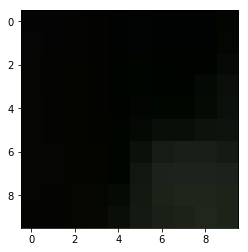

In [181]:
plt.imshow(origRoi2)

In [182]:
cap = cv2.VideoCapture(theVideo)

allPoints = []

length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# take first frame of the video
ret,frame = cap.read()
minDim = frame.shape.index(min(frame.shape[:-2]))
imgScale = minDimImage / frame.shape[minDim]
# count = 1
count = allPointsDf.iloc[0].frame

frame = cv2.resize(frame, (0,0), fx=imgScale, fy=imgScale)

r1,c1,r2,c2,currFrame = label_player(count)

p1Index = currFrame[currFrame.labels == 0].index
allPointsDf.loc[allPointsDf.index.isin(p1Index),'playerid'] = 0

p2Index = currFrame[currFrame.labels == 1].index
allPointsDf.loc[allPointsDf.index.isin(p2Index),'playerid'] = 1

h = 5
w = 5

origRoi1 = frame[r1 - h:r1 + h, c1 - w: c1 + w]
origRoi2 = frame[r2 - h:r2 + h, c2 - w: c2 + w]
player1 = origRoi1.mean(axis=0).mean(axis=0)
player2 = origRoi2.mean(axis=0).mean(axis=0)

while ret:
    count+=1
    print (f'Finding points for frame {count} out of {length}')
    ret,frame = cap.read()
    if count in list(allPointsDf.frame):
        frame = cv2.resize(frame, (0,0), fx=imgScale, fy=imgScale)
        r1,c1,r2,c2,currFrame = label_player(count)

        roi1 = frame[r1 - h:r1 + h, c1 - w: c1 + w]
        roi2 = frame[r2 - h:r2 + h, c2 - w: c2 + w]

        newPlayer1 = roi1.mean(axis=0).mean(axis=0)
        newPlayer2 = roi2.mean(axis=0).mean(axis=0)

        distMat = cosine_distances([newPlayer1,newPlayer2],[player1,player2])

        mostSimilar = distMat.argmin(axis=0)
        if mostSimilar[0] == mostSimilar[1]:
            first = mostSimilar[0]
            second = mostSimilar[1]
            if distMat[0,first] < distMat[1,second]:
                mostSimilar[1] = abs(second - 1)
            else:
                mostSimilar[0] = abs(first - 1)
    #     print(distMat, mostSimilar)
        p1Index = currFrame[currFrame.labels == 0].index
        allPointsDf.loc[allPointsDf.index.isin(p1Index),'playerid'] = mostSimilar[0]

        p2Index = currFrame[currFrame.labels == 1].index
        allPointsDf.loc[allPointsDf.index.isin(p2Index),'playerid'] = mostSimilar[1]
    
#     allPointsDf.loc[allPointsDf.labels == 0,'sim1'] = distMat[0][0]
#     allPointsDf.loc[allPointsDf.labels == 0,'sim2'] = distMat[0][1]
    
#     allPointsDf.loc[allPointsDf.labels == 1,'sim1'] = distMat[1][0]
#     allPointsDf.loc[allPointsDf.labels == 1,'sim2'] = distMat[1][1]   

/home/parker/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Finding points for frame 1 out of 2334
Finding points for frame 2 out of 2334
Finding points for frame 3 out of 2334
Finding points for frame 4 out of 2334
Finding points for frame 5 out of 2334
Finding points for frame 6 out of 2334
Finding points for frame 7 out of 2334
Finding points for frame 8 out of 2334
Finding points for frame 9 out of 2334
Finding points for frame 10 out of 2334
Finding points for frame 11 out of 2334
Finding points for frame 12 out of 2334
Finding points for frame 13 out of 2334
Finding points for frame 14 out of 2334
Finding points for frame 15 out of 2334
Finding points for frame 16 out of 2334
Finding points for frame 17 out of 2334
Finding points for frame 18 out of 2334
Finding points for frame 19 out of 2334
Finding points for frame 20 out of 2334
Finding points for frame 21 out of 2334
Finding points for frame 22 out of 2334
Finding points for frame 23 out of 2334
Finding points for frame 24 out of 2334
Finding points for frame 25 out of 2334
Finding p

Finding points for frame 211 out of 2334
Finding points for frame 212 out of 2334
Finding points for frame 213 out of 2334
Finding points for frame 214 out of 2334
Finding points for frame 215 out of 2334
Finding points for frame 216 out of 2334
Finding points for frame 217 out of 2334
Finding points for frame 218 out of 2334
Finding points for frame 219 out of 2334
Finding points for frame 220 out of 2334
Finding points for frame 221 out of 2334
Finding points for frame 222 out of 2334
Finding points for frame 223 out of 2334
Finding points for frame 224 out of 2334
Finding points for frame 225 out of 2334
Finding points for frame 226 out of 2334
Finding points for frame 227 out of 2334
Finding points for frame 228 out of 2334
Finding points for frame 229 out of 2334
Finding points for frame 230 out of 2334
Finding points for frame 231 out of 2334
Finding points for frame 232 out of 2334
Finding points for frame 233 out of 2334
Finding points for frame 234 out of 2334
Finding points f

Finding points for frame 421 out of 2334
Finding points for frame 422 out of 2334
Finding points for frame 423 out of 2334
Finding points for frame 424 out of 2334
Finding points for frame 425 out of 2334
Finding points for frame 426 out of 2334
Finding points for frame 427 out of 2334
Finding points for frame 428 out of 2334
Finding points for frame 429 out of 2334
Finding points for frame 430 out of 2334
Finding points for frame 431 out of 2334
Finding points for frame 432 out of 2334
Finding points for frame 433 out of 2334
Finding points for frame 434 out of 2334
Finding points for frame 435 out of 2334
Finding points for frame 436 out of 2334
Finding points for frame 437 out of 2334
Finding points for frame 438 out of 2334
Finding points for frame 439 out of 2334
Finding points for frame 440 out of 2334
Finding points for frame 441 out of 2334
Finding points for frame 442 out of 2334
Finding points for frame 443 out of 2334
Finding points for frame 444 out of 2334
Finding points f

Finding points for frame 631 out of 2334
Finding points for frame 632 out of 2334
Finding points for frame 633 out of 2334
Finding points for frame 634 out of 2334
Finding points for frame 635 out of 2334
Finding points for frame 636 out of 2334
Finding points for frame 637 out of 2334
Finding points for frame 638 out of 2334
Finding points for frame 639 out of 2334
Finding points for frame 640 out of 2334
Finding points for frame 641 out of 2334
Finding points for frame 642 out of 2334
Finding points for frame 643 out of 2334
Finding points for frame 644 out of 2334
Finding points for frame 645 out of 2334
Finding points for frame 646 out of 2334
Finding points for frame 647 out of 2334
Finding points for frame 648 out of 2334
Finding points for frame 649 out of 2334
Finding points for frame 650 out of 2334
Finding points for frame 651 out of 2334
Finding points for frame 652 out of 2334
Finding points for frame 653 out of 2334
Finding points for frame 654 out of 2334
Finding points f

Finding points for frame 841 out of 2334
Finding points for frame 842 out of 2334
Finding points for frame 843 out of 2334
Finding points for frame 844 out of 2334
Finding points for frame 845 out of 2334
Finding points for frame 846 out of 2334
Finding points for frame 847 out of 2334
Finding points for frame 848 out of 2334
Finding points for frame 849 out of 2334
Finding points for frame 850 out of 2334
Finding points for frame 851 out of 2334
Finding points for frame 852 out of 2334
Finding points for frame 853 out of 2334
Finding points for frame 854 out of 2334
Finding points for frame 855 out of 2334
Finding points for frame 856 out of 2334
Finding points for frame 857 out of 2334
Finding points for frame 858 out of 2334
Finding points for frame 859 out of 2334
Finding points for frame 860 out of 2334
Finding points for frame 861 out of 2334
Finding points for frame 862 out of 2334
Finding points for frame 863 out of 2334
Finding points for frame 864 out of 2334
Finding points f

Finding points for frame 1051 out of 2334
Finding points for frame 1052 out of 2334
Finding points for frame 1053 out of 2334
Finding points for frame 1054 out of 2334
Finding points for frame 1055 out of 2334
Finding points for frame 1056 out of 2334
Finding points for frame 1057 out of 2334
Finding points for frame 1058 out of 2334
Finding points for frame 1059 out of 2334
Finding points for frame 1060 out of 2334
Finding points for frame 1061 out of 2334
Finding points for frame 1062 out of 2334
Finding points for frame 1063 out of 2334
Finding points for frame 1064 out of 2334
Finding points for frame 1065 out of 2334
Finding points for frame 1066 out of 2334
Finding points for frame 1067 out of 2334
Finding points for frame 1068 out of 2334
Finding points for frame 1069 out of 2334
Finding points for frame 1070 out of 2334
Finding points for frame 1071 out of 2334
Finding points for frame 1072 out of 2334
Finding points for frame 1073 out of 2334
Finding points for frame 1074 out 

Finding points for frame 1261 out of 2334
Finding points for frame 1262 out of 2334
Finding points for frame 1263 out of 2334
Finding points for frame 1264 out of 2334
Finding points for frame 1265 out of 2334
Finding points for frame 1266 out of 2334
Finding points for frame 1267 out of 2334
Finding points for frame 1268 out of 2334
Finding points for frame 1269 out of 2334
Finding points for frame 1270 out of 2334
Finding points for frame 1271 out of 2334
Finding points for frame 1272 out of 2334
Finding points for frame 1273 out of 2334
Finding points for frame 1274 out of 2334
Finding points for frame 1275 out of 2334
Finding points for frame 1276 out of 2334
Finding points for frame 1277 out of 2334
Finding points for frame 1278 out of 2334
Finding points for frame 1279 out of 2334
Finding points for frame 1280 out of 2334
Finding points for frame 1281 out of 2334
Finding points for frame 1282 out of 2334
Finding points for frame 1283 out of 2334
Finding points for frame 1284 out 

Finding points for frame 1471 out of 2334
Finding points for frame 1472 out of 2334
Finding points for frame 1473 out of 2334
Finding points for frame 1474 out of 2334
Finding points for frame 1475 out of 2334
Finding points for frame 1476 out of 2334
Finding points for frame 1477 out of 2334
Finding points for frame 1478 out of 2334
Finding points for frame 1479 out of 2334
Finding points for frame 1480 out of 2334
Finding points for frame 1481 out of 2334
Finding points for frame 1482 out of 2334
Finding points for frame 1483 out of 2334
Finding points for frame 1484 out of 2334
Finding points for frame 1485 out of 2334
Finding points for frame 1486 out of 2334
Finding points for frame 1487 out of 2334
Finding points for frame 1488 out of 2334
Finding points for frame 1489 out of 2334
Finding points for frame 1490 out of 2334
Finding points for frame 1491 out of 2334
Finding points for frame 1492 out of 2334
Finding points for frame 1493 out of 2334
Finding points for frame 1494 out 

Finding points for frame 1681 out of 2334
Finding points for frame 1682 out of 2334
Finding points for frame 1683 out of 2334
Finding points for frame 1684 out of 2334
Finding points for frame 1685 out of 2334
Finding points for frame 1686 out of 2334
Finding points for frame 1687 out of 2334
Finding points for frame 1688 out of 2334
Finding points for frame 1689 out of 2334
Finding points for frame 1690 out of 2334
Finding points for frame 1691 out of 2334
Finding points for frame 1692 out of 2334
Finding points for frame 1693 out of 2334
Finding points for frame 1694 out of 2334
Finding points for frame 1695 out of 2334
Finding points for frame 1696 out of 2334
Finding points for frame 1697 out of 2334
Finding points for frame 1698 out of 2334
Finding points for frame 1699 out of 2334
Finding points for frame 1700 out of 2334
Finding points for frame 1701 out of 2334
Finding points for frame 1702 out of 2334
Finding points for frame 1703 out of 2334
Finding points for frame 1704 out 

Finding points for frame 1891 out of 2334
Finding points for frame 1892 out of 2334
Finding points for frame 1893 out of 2334
Finding points for frame 1894 out of 2334
Finding points for frame 1895 out of 2334
Finding points for frame 1896 out of 2334
Finding points for frame 1897 out of 2334
Finding points for frame 1898 out of 2334
Finding points for frame 1899 out of 2334
Finding points for frame 1900 out of 2334
Finding points for frame 1901 out of 2334
Finding points for frame 1902 out of 2334
Finding points for frame 1903 out of 2334
Finding points for frame 1904 out of 2334
Finding points for frame 1905 out of 2334
Finding points for frame 1906 out of 2334
Finding points for frame 1907 out of 2334
Finding points for frame 1908 out of 2334
Finding points for frame 1909 out of 2334
Finding points for frame 1910 out of 2334
Finding points for frame 1911 out of 2334
Finding points for frame 1912 out of 2334
Finding points for frame 1913 out of 2334
Finding points for frame 1914 out 

Finding points for frame 2101 out of 2334
Finding points for frame 2102 out of 2334
Finding points for frame 2103 out of 2334
Finding points for frame 2104 out of 2334
Finding points for frame 2105 out of 2334
Finding points for frame 2106 out of 2334
Finding points for frame 2107 out of 2334
Finding points for frame 2108 out of 2334
Finding points for frame 2109 out of 2334
Finding points for frame 2110 out of 2334
Finding points for frame 2111 out of 2334
Finding points for frame 2112 out of 2334
Finding points for frame 2113 out of 2334
Finding points for frame 2114 out of 2334
Finding points for frame 2115 out of 2334
Finding points for frame 2116 out of 2334
Finding points for frame 2117 out of 2334
Finding points for frame 2118 out of 2334
Finding points for frame 2119 out of 2334
Finding points for frame 2120 out of 2334
Finding points for frame 2121 out of 2334
Finding points for frame 2122 out of 2334
Finding points for frame 2123 out of 2334
Finding points for frame 2124 out 

Finding points for frame 2311 out of 2334
Finding points for frame 2312 out of 2334
Finding points for frame 2313 out of 2334
Finding points for frame 2314 out of 2334
Finding points for frame 2315 out of 2334
Finding points for frame 2316 out of 2334
Finding points for frame 2317 out of 2334
Finding points for frame 2318 out of 2334
Finding points for frame 2319 out of 2334
Finding points for frame 2320 out of 2334
Finding points for frame 2321 out of 2334
Finding points for frame 2322 out of 2334
Finding points for frame 2323 out of 2334
Finding points for frame 2324 out of 2334
Finding points for frame 2325 out of 2334
Finding points for frame 2326 out of 2334
Finding points for frame 2327 out of 2334
Finding points for frame 2328 out of 2334
Finding points for frame 2329 out of 2334
Finding points for frame 2330 out of 2334
Finding points for frame 2331 out of 2334
Finding points for frame 2332 out of 2334
Finding points for frame 2333 out of 2334


In [124]:
def plot_labels_points(idx):
    cap = cv2.VideoCapture(theVideo)
    for _ in range(idx):
        ret,frame = cap.read()
    minDim = frame.shape.index(min(frame.shape[:-2]))
    imgScale = minDimImage / frame.shape[minDim]
    frame = cv2.resize(frame, (0,0), fx=imgScale, fy=imgScale)

    plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))
    plt.scatter(allPointsDf[allPointsDf.frame==idx]['x'],allPointsDf[allPointsDf.frame==idx]['y'])

In [125]:
# pickle.dump(allPointsDf,open('point-track.pkl','wb'))

(-99.77435895768298, 1919.5, 1135.1686200024685, -0.5)

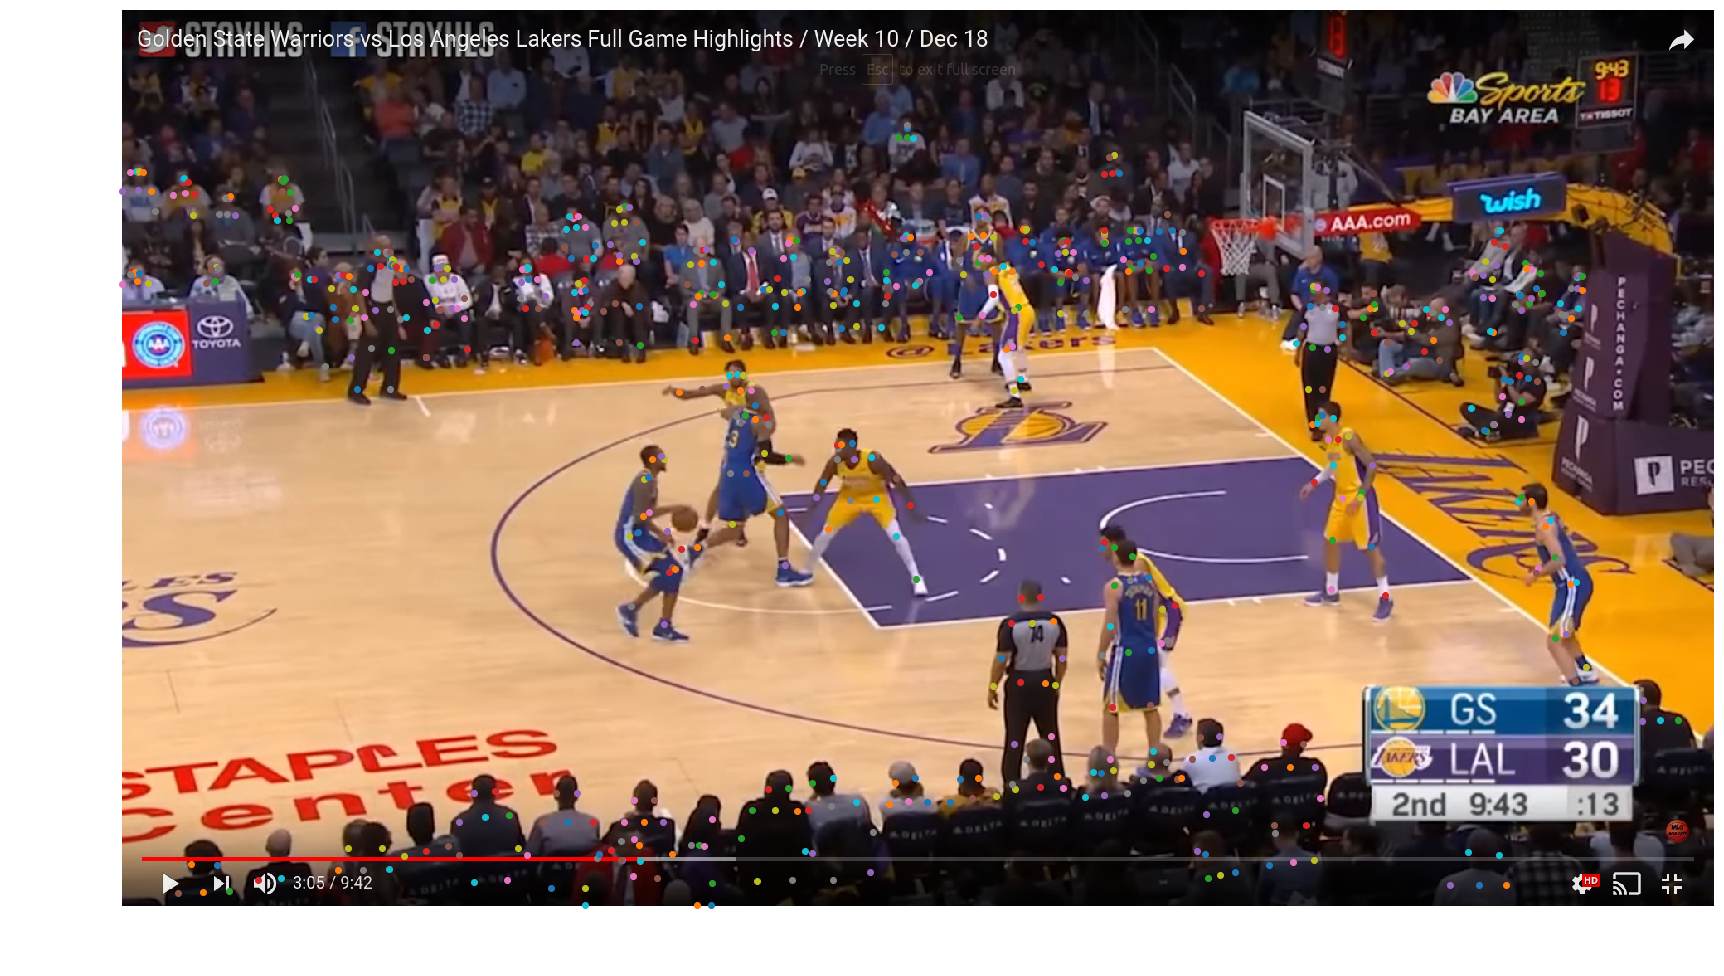

In [21]:
frame = cv2.imread('basketball.png')
plt.figure(figsize = (30,30))
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))
htm = find_heatmap(frame,5)
pks = find_peaks(htm)
peakDict = find_feet_head(pks)
for i in range(len(peakDict['x'])):
    plt.scatter(peakDict['x'][i],peakDict['y'][i])
plt.axis('off')

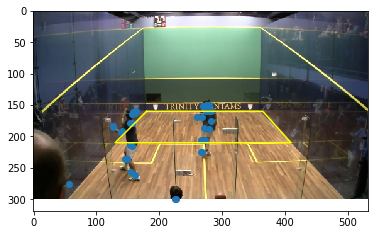

In [133]:
plot_labels_points(30)
courtX = [180,365,410,130,180]
courtY = [160,160,210,210,160]
plt.plot(courtX,courtY,c='yellow')

In [134]:
centerMassDf = allPointsDf[allPointsDf.part.isin([10,13])].copy()
centerMassDf = centerMassDf.groupby(['part','frame','playerid'])[['x','y']].median().reset_index()
centerMassDf = centerMassDf.groupby(['playerid','frame'])[['x','y']].median().reset_index()

noFeetCenterMassDf = allPointsDf[~allPointsDf.part.isin([10,13])].copy()
noFeetCenterMassDf = noFeetCenterMassDf.groupby(['part','frame','playerid'])[['x','y']].median().reset_index()
noFeetCenterMassDf = noFeetCenterMassDf.groupby(['playerid','frame'])[['x','y']].median().reset_index()

In [135]:
missingFrames = noFeetCenterMassDf[~noFeetCenterMassDf.frame.isin(centerMassDf.frame)]

In [136]:
noFeetDif = pd.merge(noFeetCenterMassDf,centerMassDf,on=['playerid','frame'])

In [137]:
noFeetDif['dif_x'] = noFeetDif['x_x'] - noFeetDif['x_y']
noFeetDif['dif_y'] = noFeetDif['y_x'] - noFeetDif['y_y']

In [138]:
differences = list(noFeetDif[['dif_x','dif_y']].mean())

In [139]:
cmAvg = centerMassDf.groupby('frame')['playerid'].mean().reset_index()

In [140]:
cmAvg.columns=['frame','playercount']

In [141]:
centerMassDf = pd.merge(centerMassDf,cmAvg,how='left',on='frame')

In [142]:
missingPlayer = pd.DataFrame(centerMassDf[centerMassDf.playercount!=.5][['playerid','frame']] - 1).apply(abs)
missingPlayer['frame'] += 1

In [143]:
missingPlayer = pd.merge(missingPlayer,allPointsDf[['playerid','frame','part','x','y']],how='inner',on=['playerid','frame'])
missingPlayer = missingPlayer.groupby(['part','frame','playerid'])[['x','y']].median().reset_index()
missingPlayer = missingPlayer.groupby(['playerid','frame'])[['x','y']].median().reset_index()

In [144]:
missingPlayer = pd.concat([missingPlayer,missingFrames])

In [145]:
missingPlayer['x'] -= differences[0]
missingPlayer['y'] -= differences[1]

In [146]:
centerMassDf = pd.concat([centerMassDf.drop(columns=['playercount']),missingPlayer])

In [147]:
def find_bottom_corners(topLeft,midLeft,topRight,midRight):
    leftSlope = (topLeft[1] - midLeft[1]) / (topLeft[0] - midLeft[0])
    rightSlope = (topRight[1] - midRight[1]) / (topRight[0] - midRight[0])

    leftDist = np.sqrt((topLeft[1] - midLeft[1])**2 + (topLeft[0] - midLeft[0])**2)
    rightDist = np.sqrt((topRight[1] - midRight[1])**2 + (topRight[0] - midRight[0])**2)
    
    bottomLeft = (midLeft[0] - leftDist * np.sqrt(1 / (1+leftSlope**2)), midLeft[1] - leftSlope*leftDist * np.sqrt(1 / (1+leftSlope**2)))
    bottomRight = (midRight[0] + rightDist * np.sqrt(1 / (1+rightSlope**2)), midRight[1] + rightSlope*rightDist * np.sqrt(1 / (1+rightSlope**2)))
    
    return bottomLeft, bottomRight

In [148]:
courtX = [180,365,410,130,180]
courtY = [160,160,210,210,160]

topLeftCorner = [180,160]
topRightCorner = [365,160]
midLeftCorner = [130,210]
midRightCorner = [410,210]
bottomLeftCorner, bottomRightCorner = find_bottom_corners(topLeftCorner,midLeftCorner,topRightCorner,midRightCorner)

In [149]:
orig = np.array([
        topLeftCorner,topRightCorner,bottomLeftCorner,bottomRightCorner
    ])
dest = np.array([
        [0,0],[504,0],[0,763],[504,763]
    ])
h , _ = cv2.findHomography(orig,dest)

In [150]:
def translate_point(x,y,h):
    
    denom = h[2,0] *x + h[2,1] * y + h[2,2]
    xPrime = (h[0,0] *x + h[0,1] * y + h[0,2])/ denom
    yPrime = (h[1,0] *x + h[1,1] * y + h[1,2]) / denom
    
    return int(xPrime),int(yPrime)

In [151]:
xList = list(centerMassDf['x'])
yList = list(centerMassDf['y'])

points = []
for x,y in zip(xList,yList):
    points.append(translate_point(x,y,h))
    
x,y = list(zip(*points))

centerMassDf['xprime'] = x
centerMassDf['yprime'] = y

In [152]:
def create_heatmap(idx,bins=25):
    pix2meter = 6.400/504
    feetOnly = centerMassDf[centerMassDf.playerid==idx]
    player = centerMassDf[centerMassDf.playerid==idx].diff().dropna().copy()
    player['dist'] = np.sqrt(player['xprime'] ** 2 + player['yprime'] ** 2)
    distTraveled = int(np.sum(player['dist']) * pix2meter)
    court = cv2.imread('squash.png')

    heatmap, xedges, yedges = np.histogram2d(feetOnly['xprime'], feetOnly['yprime'], bins=bins,normed=True)
    extent = [0, court.shape[1], court.shape[0], 0]
    plt.figure(figsize=(10,10),frameon=False)
    plt.imshow(heatmap.T, extent=extent)


    im1 = plt.imshow(court[:,:,[2,1,0]])

    im2 = plt.imshow(heatmap.T, cmap='hot_r', alpha=.9, interpolation='gaussian',extent=extent)
    plt.axis('off')
    plt.title(f'Heatmap: Player {idx}',fontsize=15)
    plt.title(f'Heatmap: Matthew',fontsize=15)
    plt.annotate(f'Court Coverage: {distTraveled} meters',(.175,.085),xycoords='figure fraction',fontsize=12)
    plt.show()
    

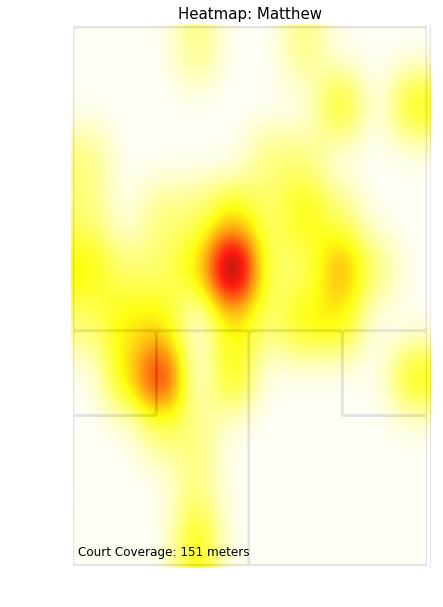

In [161]:
create_heatmap(0,10)

In [76]:
centerMassDf.sort_values('frame',inplace=True)

In [156]:
count = -1
court = cv2.imread('squash.png')
rollingAvgCount = 3
rollingAvgP0X = [centerMassDf[centerMassDf.playerid == 0].iloc[0]['xprime']] * rollingAvgCount
rollingAvgP1X = [centerMassDf[centerMassDf.playerid == 1].iloc[0]['xprime']] * rollingAvgCount

rollingAvgP0Y = [centerMassDf[centerMassDf.playerid == 0].iloc[0]['yprime']] * rollingAvgCount
rollingAvgP1Y = [centerMassDf[centerMassDf.playerid == 1].iloc[0]['yprime']] * rollingAvgCount
ret = True
height, width,channels = court.shape
# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v') # Be sure to use lower case
# out = cv2.VideoWriter('abstraction.avi', fourcc, 30.0, (width, height))

while ret:
    count +=1
    print(count)
    frameDf = centerMassDf[centerMassDf.frame == count]
    if len(frameDf)!=0:        
        
        rollingAvgP0X = rollingAvgP0X[1:] + [int(frameDf[frameDf.playerid == 0]['xprime'])]
        rollingAvgP1X = rollingAvgP0X[1:] + [int(frameDf[frameDf.playerid == 1]['xprime'])]
        
        rollingAvgP0Y = rollingAvgP0Y[1:] + [int(frameDf[frameDf.playerid == 0]['yprime'])]
        rollingAvgP1Y = rollingAvgP0Y[1:] + [int(frameDf[frameDf.playerid == 1]['yprime'])]
        points = [
            (int(np.mean(rollingAvgP0X)),int(np.mean(rollingAvgP0Y)),0),\
            (int(np.mean(rollingAvgP1X)),int(np.mean(rollingAvgP1Y)),1)
        ]
        if count %(3*rollingAvgCount) == 0:
            img2 = deepcopy(court)
            for pts in points:
                img2 = cv2.circle(img2, pts[:2], 10,thickness=10,color=pts[-1]*1000)
                if pts[-1] == 0:
                    cv2.putText(img2,'Matthew', (pts[0] - 20,pts[1]-20),cv2.FONT_HERSHEY_SIMPLEX,.5,1)
                else:
                    cv2.putText(img2,'Elias', (pts[0] - 20,pts[1]-20),cv2.FONT_HERSHEY_SIMPLEX,.5,1)
        
#         out.write(img2)
        cv2.imshow('Tracking',img2)
        k = cv2.waitKey(10) & 0xff
        if k == 27:
            break
        else:
            cv2.imwrite(chr(k)+".jpg",img2)
       
    else:
        ret = False
    
# out.release()
cv2.destroyAllWindows()

0


TypeError: cannot convert the series to <class 'int'>